#Word2Vec using Gensim
We will create word vectors using the Word2Vec model from the Wikipedia data of all the countries that we have saved in ‘countries.json’.

In [ ]:
!pip install gensim

## Libraries required for this notebook

In [20]:
import json
from collections import Counter
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import utils

%matplotlib inline

## Exploratory data analysis

In [ ]:
#load and display the data
with open('/content/countries.json') as fout:
   countries= json.load(fout)

In [ ]:
# Display records

countries['India'][:10]

['India',
 'Hindi',
 'Bhārat',
 'officially',
 'the',
 'Republic',
 'of',
 'India',
 'Hindi',
 'Bhārat']

This is essentially first 10 characters from [wiki page](https://en.wikipedia.org/wiki/India) of India. This might not exactly match as the wiki page is updating frequently.

Let's check for some other countries to understand the data better.

In [ ]:
print(' '.join(countries['India'][:10]),'.....')

India Hindi Bhārat officially the Republic of India Hindi Bhārat .....


In [ ]:
for i, (country, text) in enumerate(countries.items()):
  print(country)
  print(' '.join(text)[:512]+'.....')
  print('-'*100)
  if i>=5:
    break

Afghanistan
Afghanistan listen Pashto Dari افغانستان Pashto Afġānistān avɣɒnisˈtɒn ab Dari Afġānestān avɣɒnesˈtɒn officially the Islamic Republic of Afghanistan is a mountainous landlocked country at the crossroads of Central and South Asia Afghanistan is bordered by Pakistan to the east and south Iran to the west Turkmenistan Uzbekistan and Tajikistan to the north and China to the northeast Occupying 652 000 square kilometers 252 000 sq mi it is a mountainous country with plains in the north and southwest Kabul is the.....
----------------------------------------------------------------------------------------------------
Albania
Albania listen a w l BAY nee ə Albanian Shqipëri or Shqipëria officially the Republic of Albania Albanian Republika e Shqipërisë is a country in Southeastern Europe It is located on the Adriatic and Ionian Sea within the Mediterranean Sea and shares land borders with Montenegro to the northwest Kosovo to the northeast North Macedonia to the east Greece to the

## Word2Vec operations

In [ ]:
# Create and train simple model
model= Word2Vec(sentences=countries.values())

`sentences` select one or multiple sentences from a text corpus.

In [ ]:
# Check word similarite learnt by the model
model.wv.most_similar('India', topn=5)

[('Brazil', 0.868915319442749),
 ('Iran', 0.8395805358886719),
 ('China', 0.8319586515426636),
 ('Russia', 0.7876300811767578),
 ('Mozambique', 0.7846744060516357)]

Most similar words to 'India'. Note that this makes sense because each of the words listed as similar to India are essentially also countries. Apparently other than the fact that these are countries, there is a very little coherence interm of geographical similarity , ethnical similarity etc.

Let's try to evaluate the loss of the model. 

In [ ]:
model= Word2Vec(sentences= countries.values(), compute_loss=True)

model.get_latest_training_loss()

5179403.5

Now the issue is that loss is very relative. It depends on the volume of data , selection of loss model etc. Now from our knowledge of deep NN , we know that loss is computed step by step i.e. in each epoch.

### Word2Vec options


In [22]:
Word2Vec?

List of key parameters in Word2Vec function

|parameter name|refrence|
|---|---|
|sentences| The `sentences` iterable , for larger corpora,consider an iterable that streams the sentences|
|size|Dimensionality of the word vectors|
|iter|Number of iterations (epochs) over the corpus|
|min_alpha|Learning rate will linearly drop to `min_alpha` as training progresses.|
|seed |Reporoducible run|
|window|Similar to context size , Maximum distance between the current and predicted word within a sentence.|
|min_count|Ignores all words with total frequency lower than this|
|sg|Training algorithm: 1 for skip-gram; otherwise CBOW, default is 0|
|max_vocab_size|Limits the RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. |
|trim_rule|specifies whether certain words should remain in the vocabulary|
|callbacks|Iterable piece of code, essentially printing the loss of each epoch|

### Heuristics for Word2Vec algorithms

Determine size of vocabulary

In [ ]:
counter= Counter()

for corpus in countries.values():
  for word in corpus:
    counter.update([word])

print(len(counter))

85125


There are 85215 unique words in the json file

In [ ]:
len(model.wv.vocab)

21092

The model vocabulary has 21092 words , where as the text corpus has almost 4 times unique words ~85125. Let's see how can we improve this.
We modify the following:
- every = 1, print loss after each epoch
- size = 128
- iter =10
- max_vocab_size = 65336, Maximum vocabulary size (some what random) , but it has been increased from 21k to 65k

In [26]:
# Retrain - the model

metric= utils.MetricCallback(every=1)

model= Word2Vec(
    sentences= countries.values(),
    size=128,
    iter=20,
    max_vocab_size=65336,
    compute_loss=True,
    callbacks=[metric]
)

Loss after epoch 0: 1393629.625
Loss after epoch 1: 1169223.875
Loss after epoch 2: 936317.25
Loss after epoch 3: 906939.75
Loss after epoch 4: 723148.0
Loss after epoch 5: 712315.0
Loss after epoch 6: 691008.5
Loss after epoch 7: 688304.0
Loss after epoch 8: 642644.0
Loss after epoch 9: 666331.0
Loss after epoch 10: 569162.0
Loss after epoch 11: 603914.0
Loss after epoch 12: 569860.0
Loss after epoch 13: 574176.0
Loss after epoch 14: 539663.0
Loss after epoch 15: 557732.0
Loss after epoch 16: 551761.0
Loss after epoch 17: 513454.0
Loss after epoch 18: 510459.0
Loss after epoch 19: 542702.0


We have now visibility of progress in loss over 10 epochs

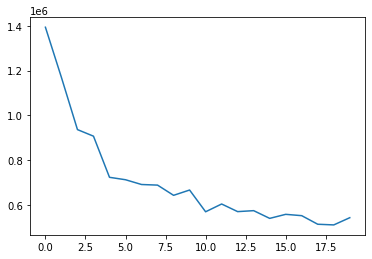

In [28]:
plt.plot(metric.myloss)
plt.show()

Around 10 epoch onwards the error have stabilzed around 55000. <br>
We will now run our experiemnt again , to see if we have received any improvement for word similaries of word 'India'.

In [29]:
# Check word similarite learnt by the model
model.wv.most_similar('India', topn=5)

[('China', 0.6077536344528198),
 ('Nepal', 0.5717543363571167),
 ('Japan', 0.5608701109886169),
 ('Malaysia', 0.5457068085670471),
 ('Pakistan', 0.5452976822853088)]

Clearly now it shows that the words are not only now merely some other country , but also they are mostly neighbor of India. Let's increase the epochs to 100, we also include worker =5  to enable multicore operation (if available) with faster evaluation. We also introduced a learning rate through `min_alpha` - Learning rate will linearly drop to `min_alpha` as training progresses.

In [30]:
# Retrain - the model

metric= utils.MetricCallback(every=10)

model= Word2Vec(
    sentences= countries.values(),
    size=128,
    iter=100,
    max_vocab_size=65336,
    compute_loss=True,
    callbacks=[metric],
    min_alpha=0.001,
    workers=5
)

Loss after epoch 0: 854508.3125
Loss after epoch 10: 391244.5
Loss after epoch 20: 328197.0
Loss after epoch 30: 313610.0
Loss after epoch 40: 302096.0
Loss after epoch 50: 244460.0
Loss after epoch 60: 232800.0
Loss after epoch 70: 225832.0
Loss after epoch 80: 220616.0
Loss after epoch 90: 200978.0


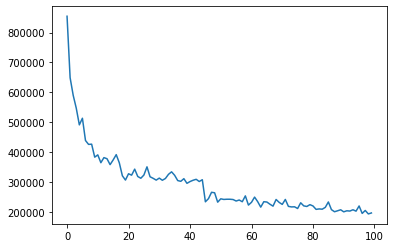

In [31]:
plt.plot(metric.myloss)
plt.show()

There is some additional learning happened from between cohort 40 to 50.

In [32]:
# Check word similarite learnt by the model
model.wv.most_similar('India', topn=5)

[('Nepal', 0.5746040344238281),
 ('China', 0.5438891649246216),
 ('Pakistan', 0.5242709517478943),
 ('Singapore', 0.5211586952209473),
 ('Indonesia', 0.5115697383880615)]

Now we see , country like Japan , which is in south east Asia , but not necessarily neighbor like country is dropped from similarity list.

In [34]:
# Examine the vector space

X =['India', 'Pakistan', 'Bangladesh', 'France', 'England', 'Spain']
Y=['Delhi', 'Islamabad', 'Dhaka', 'Paris', 'London', 'Madrid']


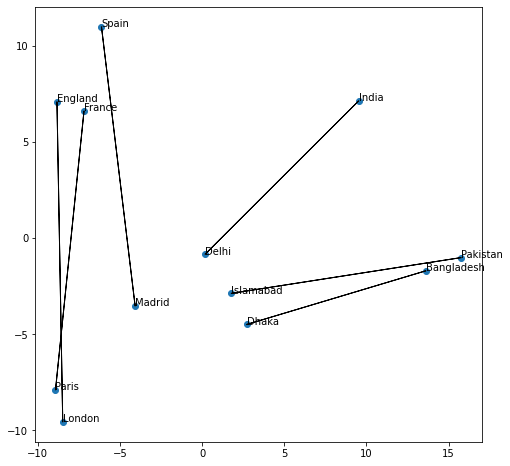

In [35]:
utils.plot_arrows(X, Y, model.wv)

These are some importaint findings. If we consider the lines joining country and capital as vectors and angle between them from knowlege of cosing similarity ( 0: Similar , 90: not related etc.), then we notice that :
- European countries are more or less parallel to each other in vertical direction. i.e. they are similar.
- On the other hand bangladesh, pakistan (somewhat India) is parallel to each other but in horizental direction , so they are also similar but different from european countries

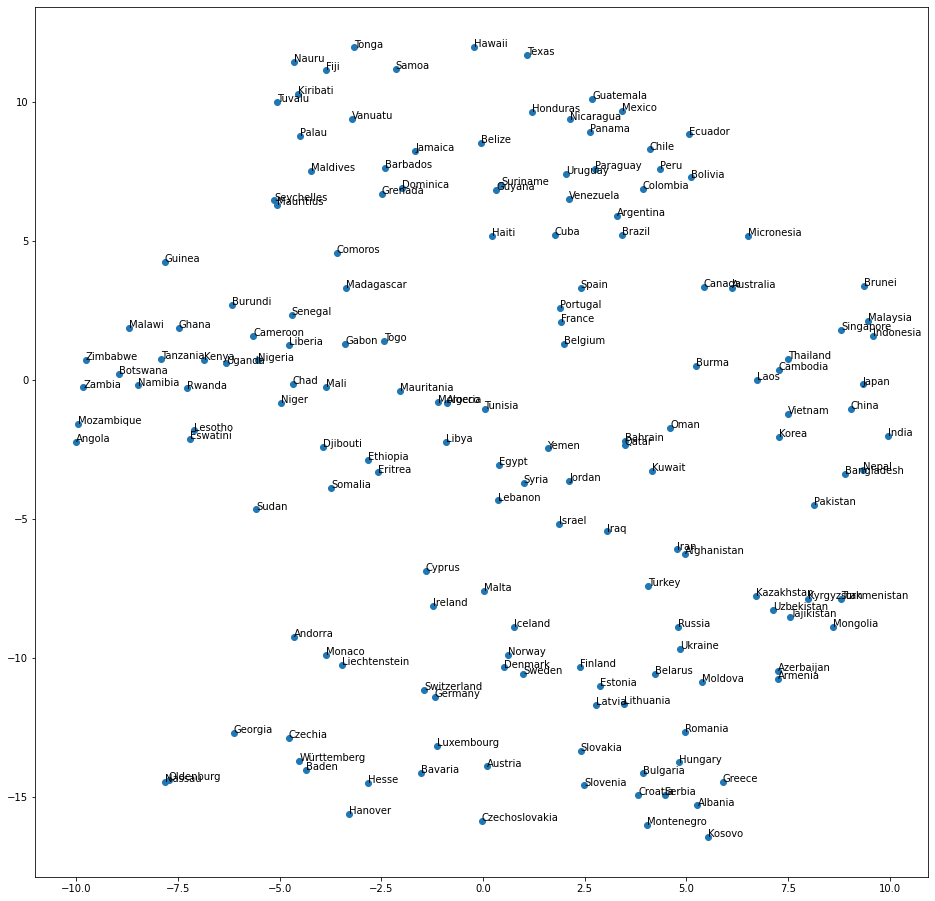

In [36]:
# Visualize vectors for all countries

utils.plot_vectors(countries, model)

Here also we have some important learning. If we consider geographical location of these countries , then we see continent like Asia (India, China, Japan , Vietnam , Bangladesh, Barma, Pakistan etc.) , Europe (germany, Luxembourg, Austria, Malta , Denmark etc.) , Africa ( Gahan, Chad , Angola, Mozambique etc.) are clustered together.

### Word Analogies

In [37]:
# India: Ganges -> Brazil -> _ ?

model.wv.most_similar(positive=['Ganges', 'Brazil'], negative=['India'])

[('river', 0.4742494523525238),
 ('Amazon', 0.45790499448776245),
 ('Napo', 0.4515100121498108),
 ('rivers', 0.4383355379104614),
 ('Putumayo', 0.431101530790329),
 ('Plata', 0.427232563495636),
 ('Paraná', 0.42207059264183044),
 ('Río', 0.40180808305740356),
 ('Guayas', 0.39966243505477905),
 ('Loja', 0.3951593041419983)]

We may think of the example :
King + Queen - Men = Women

In above , we are try to ask : Ganges + Brazil - India - i.e If India => Ganges (i.e River in India) then what is a river in Brazil

In [41]:
# America: Washington -> France: _ ?
model.wv.most_similar(positive=['Washington', 'France'], negative=['America'])

[('arbitration', 0.4133111834526062),
 ('Paris', 0.41318488121032715),
 ('1899', 0.4071112275123596),
 ('French', 0.40642809867858887),
 ('Arnold', 0.3833273649215698),
 ('Pierre', 0.3777203857898712),
 ('London', 0.37340599298477173),
 ('Garibaldi', 0.36822745203971863),
 ('UK', 0.36601030826568604),
 ('Antoine', 0.35741665959358215)]

This question is trickier. Washing is a capital of USA and at the same time G Washington was president of USA. Thus we see both presidents like Arnold , Pierre of france and at the same time capita Paris

In [42]:
# India: Hindi -> Germany: _ ?
model.wv.most_similar(positive=['Hindi', 'Germany'], negative=['India'])


[('German', 0.47442173957824707),
 ('Georg', 0.3979489803314209),
 ('Austrians', 0.3769625723361969),
 ('Silesia', 0.375221848487854),
 ('Franz', 0.3647988438606262),
 ('Leibniz', 0.36337512731552124),
 ('Kurt', 0.3617326617240906),
 ('Basel', 0.3603493273258209),
 ('Nuremberg', 0.3569595217704773),
 ('magazines', 0.3563556671142578)]

### Save and reuse a saved model

In [43]:
# Save the model
model.save('wiki-countries.w2v')

In [44]:
# Load saved model

from gensim.models import KeyedVectors
model= KeyedVectors.load('wiki-countries.w2v')